In [9]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from typing import Annotated
from typing_extensions import TypedDict 

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[str], add_messages]

graph_builder = StateGraph(State)

In [5]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-haiku-20240307")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# build the graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# compile the graph
graph = graph_builder.compile()

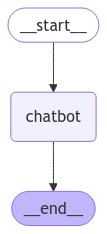

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

In [6]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: LangGraph is a framework for developing interactive language models using knowledge graphs. It aims to combine the strengths of large language models and structured knowledge representations to create more intelligent and informative conversational agents.

Some key features and capabilities of LangGraph include:

1. Knowledge Integration: LangGraph allows language models to leverage structured knowledge from knowledge graphs, enabling them to reason about facts, concepts, and relationships.

2. Contextual Understanding: By incorporating knowledge graph information, LangGraph models can better understand the context and semantics of language, leading to more coherent and informative responses.

3. Explainability: LangGraph provides transparency into the model's reasoning process by exposing the relevant knowledge graph components used to generate responses.

4. Scalability: The framework is designed to be scalable, allowing for the integration of large-scale knowledge graphs

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
out = tool.invoke("What's a 'node' in LangGraph?")


In [31]:
import textwrap

width = 70
for i, c in enumerate(out):
    print(width * '-')
    print('url:', c['url'])
    print('# Content')
    print(textwrap.fill(c['content'], width=width))

----------------------------------------------------------------------
url: https://langchain-ai.github.io/langgraph/concepts/low_level/
# Content
Nodes¶ In LangGraph, nodes are typically python functions (sync or
async) where the first positional argument is the state, and
(optionally), the second positional argument is a "config", containing
optional configurable parameters (such as a thread_id). Similar to
NetworkX, you add these nodes to a graph using the add_node method:
----------------------------------------------------------------------
url: https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141
# Content
Nodes: Nodes are the building blocks of your LangGraph. Each node
represents a function or a computation step. You define nodes to
perform specific tasks, such as processing input, making ...


In [35]:
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

In [36]:
import json 

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call['name'],
                    tool_call_id=tool_call['id']
                )
            )
        return messages
    
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)